<a href="https://colab.research.google.com/github/ljkrajewski/jupyter_notebooks/blob/main/flux_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Enter parameters
model_name = "Flux schnell" #@param ["Flux dev", "Flux schnell"]
positive_prompt = "realistic, chalk drawing, not anime, distant wide-angle full-body view, adult goth woman wearing black tank top and black skinny jeans, barefoot (on left) face-to-face with oversized (octopus-like:1.5) eldritch god Cthulhu (on right) in a dark forest"  #@param {type: "string"}
height = 768 #@param {type: "integer"}
width = 1360 #@param {type: "integer"}
#@markdown See cell below for determining height & width.
seed = 0 #@param {type: "integer"}
#@markdown Enter '0' for a random seed.
steps = 4 #@param {type: "integer"}
#@markdown Recommended steps = 20 for 'dev', 4 for 'schnell'.


if model_name == "Flux dev":
    model_download = "https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors"
elif model_name == "Flux schnell":
    model_download = "https://huggingface.co/black-forest-labs/FLUX.1-schnell/resolve/main/flux1-schnell.safetensors"

model_filename = model_download.rsplit('/', 1)[-1]

### Setting height and width
To determine the hight and length given a desired ratio $w:h$:
1.   Solve for $c$:<br> $c = \sqrt(1024^2 / wh)$
2.   To get the desired resolution, multiply $h$ and $w$ by $c$, then round both $h$ and $w$ to the closest multiple of 16.

| Ratio | Resolution |
| ----- | ---------- |
| 1:1   | 1024*1024  |
| 2:1   | 1456*720   |
| 4:3   | 1184*880   |
| 7:4 / 16:9  | 1360*768   |

Ratios listed are for landscape orientation. For portrait orientation, switch the values for height and width.

In [ ]:
#@title Load TotoroUI
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.27.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M $model_download -d /content/TotoroUI/models/unet -o $model_filename
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet(model_filename, "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 13250, done.
remote: Counting objects: 100% (3002/3002), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 13250 (delta 2911), reused 2840 (delta 2840), pack-reused 10248 (from 1)
Receiving objects: 100% (13250/13250), 7.13 MiB | 19.79 MiB/s, done.
Resolving deltas: 100% (9019/9019), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.5 MB/s eta 0:00:00
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Selecting previously unselected package l

/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/tra

17199222690461515973


  0%|          | 0/4 [00:00<?, ?it/s]

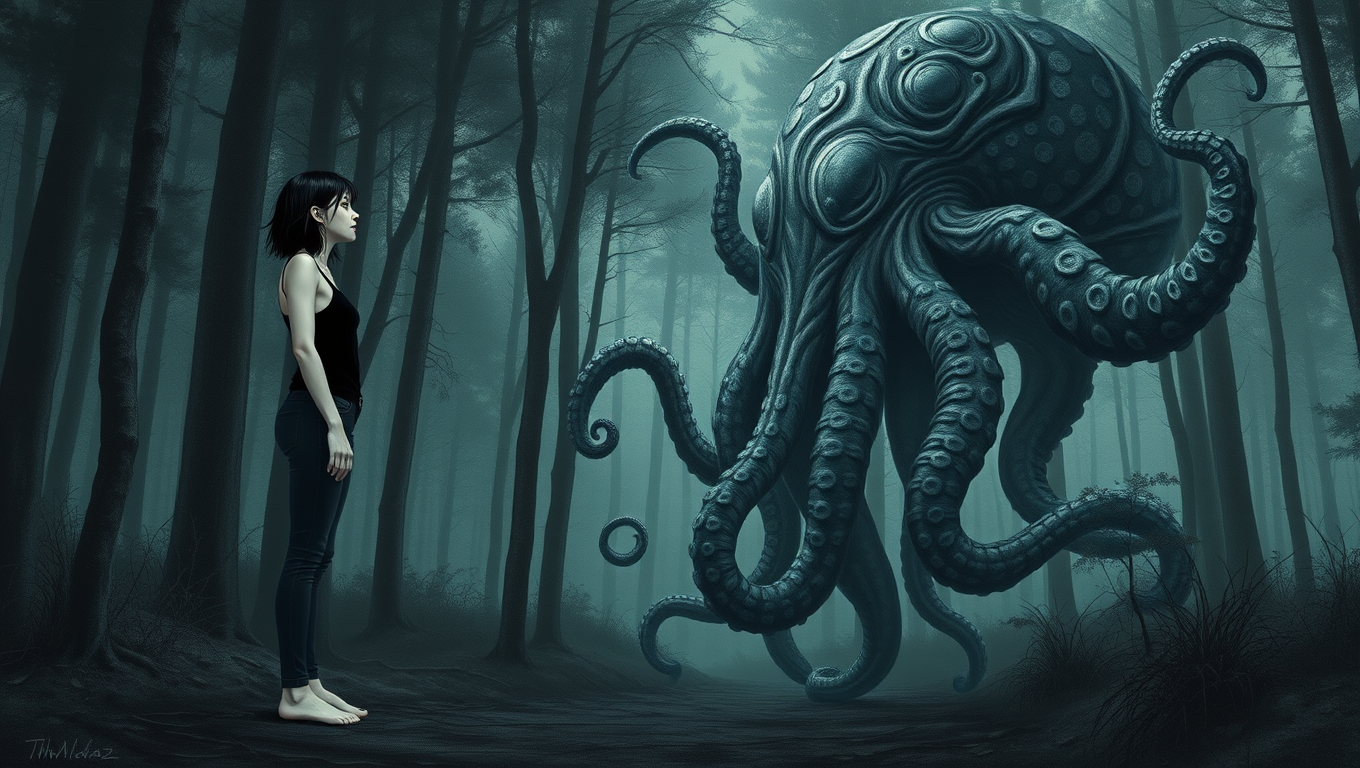

In [ ]:
#@title Create Image
with torch.inference_mode():
    #positive_prompt = "photograph, realistic, not anime, distant wide-angle full-body view, adult goth woman wearing black tank top and black skinny jeans, barefoot (on left) face-to-face with oversized (octopus-like:1.5) eldritch god Cthulhu (on right) in a dark forest"
    #height = 768
    #width = 1360
    #seed = 0 #11533083087524471363
    #steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])